# Training of Model 1

This training of the first model iteration takes place in this AWS Sagemaker notebook instance. 

There is an analysis of how the training went at the end of the notebook.

### TLDR of Analysis: 
model underfit due to low convolutional capacity before massive linear layer. Also, potentially data augmentation hurt performance.

### Load Model

In [1]:
from model import BiEncoder

# create model instance, assigning cosine similarity threshold 
signature_model = BiEncoder(threshold=0.5)

In [2]:
total_params = sum(p.numel() for p in signature_model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 460536


In [3]:
import torch

example_tensor = torch.rand([1, 2, 1, 50, 150])

output = signature_model(example_tensor)

print(output.shape)
print(output)

print(signature_model)

torch.Size([1])
tensor([1.])
BiEncoder(
  (conv_layer_1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer_2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer_3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer_4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer_5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer_6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear_layer): Linear(in_features=3456, out_features=128, bias=True)
)


### Load Data

In [4]:
import os
import torch

data_dir = os.path.join(os.getcwd(), "data")

# load train examples and labels
train_examples = torch.load(os.path.join(data_dir, "train_examples.pt"))
train_labels = torch.load(os.path.join(data_dir, "train_labels.pt"))

#laod val examples and labels
val_examples = torch.load(os.path.join(data_dir, "val_examples.pt"))
val_labels = torch.load(os.path.join(data_dir, "val_labels.pt"))

#set requires_grad to True for data so backpropagation works
train_examples.requires_grad = True
train_labels.requires_grad = True
val_examples.requires_grad = True
val_labels.requires_grad = True

### Create Tensor Dataset
The Tensor_To_Dataset is a custom subclass of torchs Dataset module that will be used to seperate the labels and features. As well as give the features the __len__ and __getitem__ methods

In [5]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(train_examples, train_labels)

val_dataset = TensorDataset(val_examples, val_labels)

### Wrap in Dataloader

In [6]:
from torch.utils.data import DataLoader

# create train and val dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)

### Test Training Environment

In [7]:
from train import Trainer
import torch.nn as nn

#set criterion and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(signature_model.parameters(), lr=0.00001)

#set epochs
epochs = 1000

#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

#set early stopping patience
patience = 30

#set log frequency for model eval 
log_frequency = 1

# create trainer instance
trainer = Trainer( model = signature_model,
                   criterion = criterion, 
                   optimizer = optimizer, 
                   train_loader = train_dataloader, 
                   val_loader = val_dataloader, 
                   epochs = epochs, 
                   device = device, 
                   early_stopping_patience = patience, 
                   log_freq = log_frequency)

Device: cuda


Train the Model

In [8]:
model, loss_curve, acc_curve = trainer.train()

Epoch: 0, Validation Accuracy: 0.6171617161716172, Validation Loss: 4.785478547854786
Epoch: 1, Validation Accuracy: 0.6171617161716172, Validation Loss: 4.785478547854786
Epoch: 2, Validation Accuracy: 0.6171617161716172, Validation Loss: 4.785478547854786
Epoch: 3, Validation Accuracy: 0.6171617161716172, Validation Loss: 4.785478547854786
Epoch: 4, Validation Accuracy: 0.6171617161716172, Validation Loss: 4.804730473047305
Epoch: 5, Validation Accuracy: 0.6171617161716172, Validation Loss: 4.785478547854786
Epoch: 6, Validation Accuracy: 0.6171617161716172, Validation Loss: 4.785478547854786
Epoch: 7, Validation Accuracy: 0.6171617161716172, Validation Loss: 4.785478547854786
Epoch: 8, Validation Accuracy: 0.6171617161716172, Validation Loss: 4.785478547854786
Epoch: 9, Validation Accuracy: 0.6171617161716172, Validation Loss: 4.785478547854786
Epoch: 10, Validation Accuracy: 0.6171617161716172, Validation Loss: 4.785478547854786
Epoch: 11, Validation Accuracy: 0.6171617161716172, V

### Plot Learning Curves Function

In [10]:
import matplotlib.pyplot as plt

def plot_learning_curves(historical_loss, historical_acc):
    """
    Plots the learning curves for loss and accuracy on the validation set.
    
    :param historical_loss: List containing the validation loss for each epoch.
    :param historical_acc: List containing the validation accuracy for each epoch.
    """
    
    epochs = range(1, len(historical_loss) + 1)
    
    # Plotting the Loss Curve
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, historical_loss, 'r', label='Validation Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plotting the Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, historical_acc, 'b', label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


###  Model 1 Learning Curve --- Trained with lr=0.001 --- Similarity Threshold 0.5

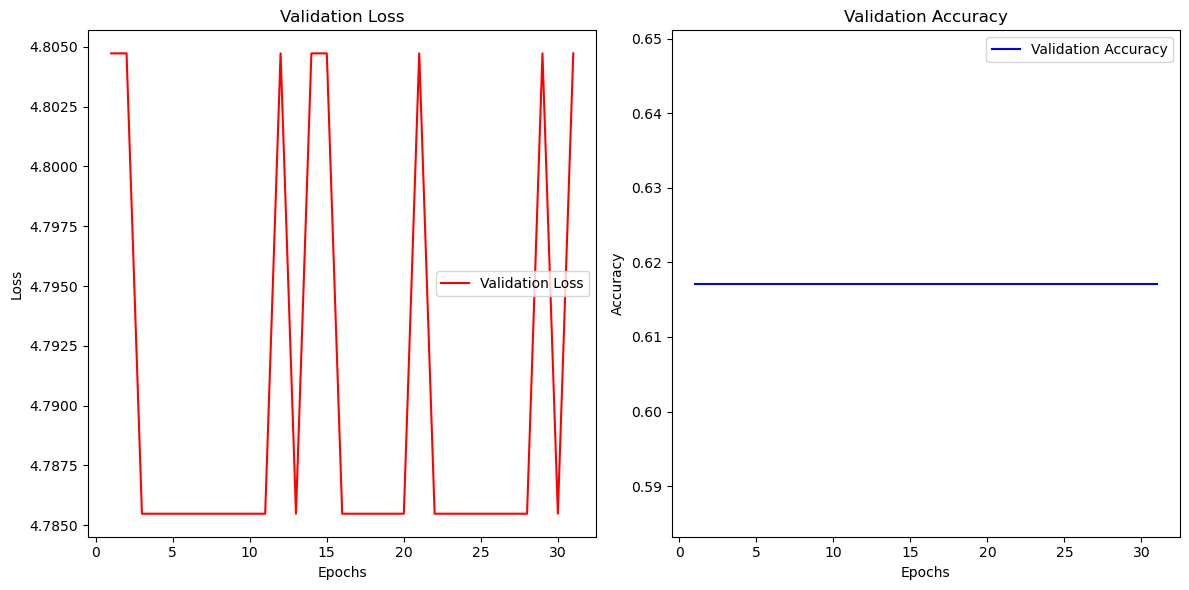

In [14]:
model, loss, acc = best_model

plot_learning_curves(loss_curve, acc_curve)

### Model 1 Learning Curve --- Trained with lr=0.01 --- Similarity Threshold 0.5

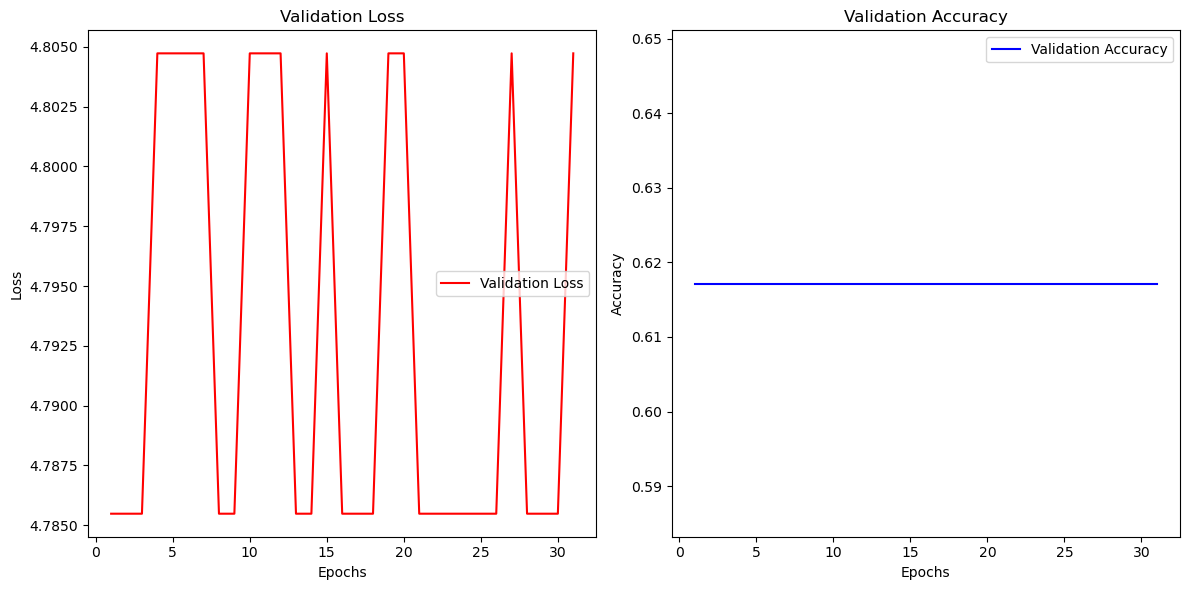

In [18]:
plot_learning_curves(loss_curve, acc_curve)

### Model 1 Learning Curve --- Trained with lr=0.0001 --- Similarity Threshold 0.5

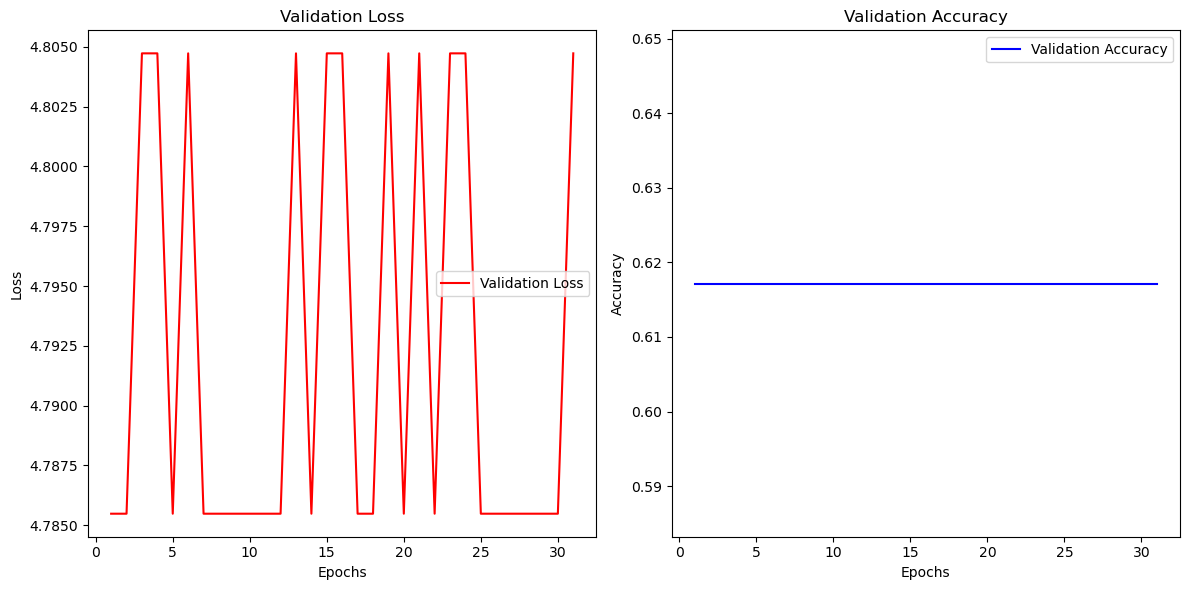

In [22]:
plot_learning_curves(loss_curve, acc_curve)

### Model 1 Learning Curve --- Trained with lr=0.0001 --- Similarity Threshold 0.15

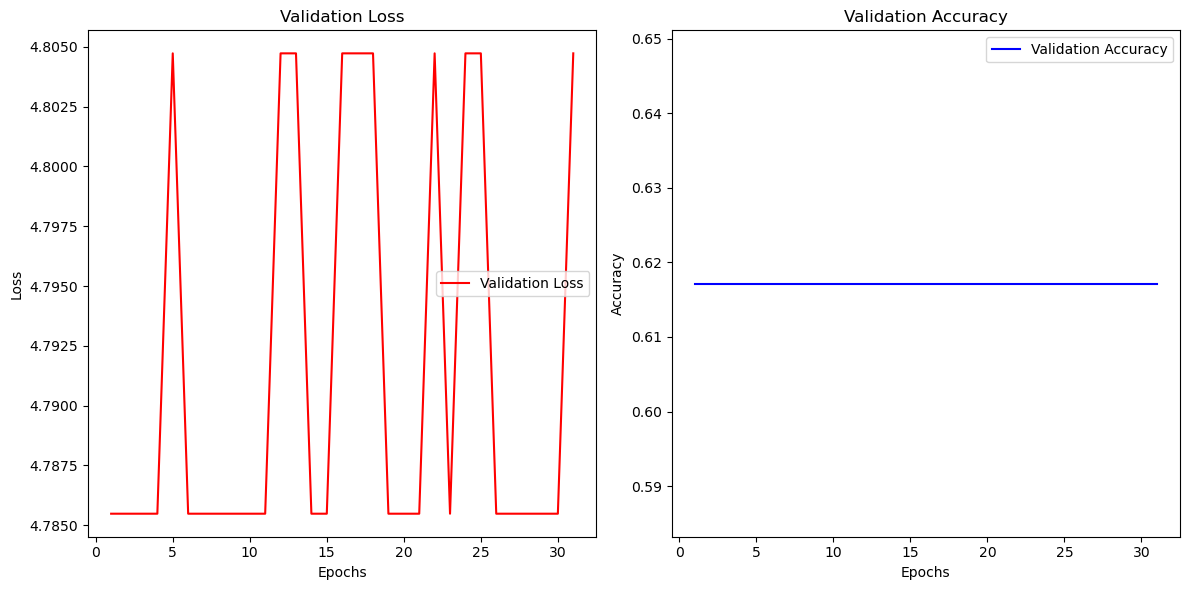

In [11]:
plot_learning_curves(loss_curve, acc_curve)

# Analysis

The training of the inititial model did not go well. The model severely underfit the data, making no progress in reducing the loss. Interestingly, the model reached an accuracy of 62% out of the gate. However, this can be accounted for by the targets binary and grouped into roughly 60-40 splits for positive to negative examples. 

### The following are some speculations as to why this result happened.

- The max pooling dimmensionality reduction prior to training eliminated valuable information from examples. I see this as one of two most likely areas for improvement. While the quality of the images was such that I could still tell whose signature was whose, it is possible the task of classifying these reduced images is much more complicated than that of those with higher resolutions.

- The model is too simple to learn the distribution. Below, I have printed out the number of parameters at each layer of the model. Layer 13 is the linear layer that reduces the the flatted output of the convolutional blocks into the 128 dimmensional vector. This is a common oversight I've made before when training convolutional classifiers. That is, when the vast bulk of the weights are in the final linear layers, it means the conv layers are likely to underfit the data and undermine all those linear parameters. This can be addressed by creating a more inified flow of parameter growth throughout the forward pass.


In [13]:
total_params = [p.numel() for p in signature_model.parameters()]

for i, param_num in enumerate(total_params):
    print(f'Layer {i+1}: {param_num}')

Layer 1: 72
Layer 2: 8
Layer 3: 576
Layer 4: 8
Layer 5: 1152
Layer 6: 16
Layer 7: 2304
Layer 8: 16
Layer 9: 4608
Layer 10: 32
Layer 11: 9216
Layer 12: 32
Layer 13: 442368
Layer 14: 128
